<a href="https://colab.research.google.com/github/Eoligbi/Supply-Chain-Management-Using-PPO-Algorithm-for-Reinforcement-Learning-/blob/main/SCO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project, the required libraries to install are as follows: Ensure they're properly installed
1. numpy
2. pandas
3. gymnasium  
4. tensorflow
5. boto3
6. stable-baselines3
7. matplotlib **bold text**


In [1]:
!pip install numpy pandas gym tensorflow boto3



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 5.0 MB/s eta 0:00:00


In [11]:
!pip install stable-baselines3 matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 23.1 MB/s eta 0:00:00


Environment Definition of the SupplyChainEnv Class:
A custom Gym environment representing the supply chain. **bold text** **bold text**

This part considers the Algorithm:PPO

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from gym import spaces, Env



class SupplyChainEnv(Env):
    def __init__(self):
        super(SupplyChainEnv, self).__init__()


        # Parameters for each of the node type
        self.supplier_capacity = 100
        self.factory_capacity = 80
        self.warehouse_capacity = 200
        self.retailer_demand = 50

        # Initial inventories(The numbers are arbitrarily selected)
        self.supplier_inventory = 100
        self.factory_inventory = 50
        self.warehouse_inventory = 30
        self.retailer_inventory = 10

        # Action and Observation spaces
        self.action_space = spaces.Box(low=0, high=1, shape=(3,), dtype=np.float32)  # Three actions (supply order, production rate, warehouse shipping rate)
        self.observation_space = spaces.Box(low=0, high=200, shape=(4,), dtype=np.float32)  # Inventory levels of each node

    def reset(self):
        # Reset inventory levels
        self.supplier_inventory = 100
        self.factory_inventory = 50
        self.warehouse_inventory = 30
        self.retailer_inventory = 10
        return np.array([self.supplier_inventory, self.factory_inventory, self.warehouse_inventory, self.retailer_inventory], dtype=np.float32)

    def step(self, action):
        # Decode actions (scale values for real-world impact)
        supply_order = int(action[0] * self.supplier_capacity)
        production_rate = int(action[1] * self.factory_capacity)
        shipping_rate = int(action[2] * self.warehouse_capacity)

        # Update inventories based on actions
        self.supplier_inventory = max(self.supplier_inventory - supply_order, 0)
        self.factory_inventory = min(self.factory_inventory + supply_order - production_rate, self.factory_capacity)
        self.warehouse_inventory = min(self.warehouse_inventory + production_rate - shipping_rate, self.warehouse_capacity)
        self.retailer_inventory = min(self.retailer_inventory + shipping_rate - self.retailer_demand, 50)  # Maximum retailer storage

        # Defining costs and rewards
        inventory_cost = 0.1 * (self.supplier_inventory + self.factory_inventory + self.warehouse_inventory)
        shortage_cost = 1.0 * max(self.retailer_demand - self.retailer_inventory, 0)

        # Reward is negative of total cost
        reward = -(inventory_cost + shortage_cost)

        # Observation of current state
        state = np.array([self.supplier_inventory, self.factory_inventory, self.warehouse_inventory, self.retailer_inventory], dtype=np.float32)

        # Terminate if shortage occurs
        done = True if self.retailer_inventory <= 0 else False

        return state, reward, done, {}

    def render(self):
        print(f"Supplier: {self.supplier_inventory}, Factory: {self.factory_inventory}, Warehouse: {self.warehouse_inventory}, Retailer: {self.retailer_inventory}")




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.85     |
|    ep_rew_mean     | -72.6    |
| time/              |          |
|    fps             | 873      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 3.02       |
|    ep_rew_mean          | -18.9      |
| time/                   |            |
|    fps                  | 666        |
|    iterations           | 2          |
|    time_elapsed         | 6          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.23893327 |
|    clip_fraction        | 0.559      |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.2

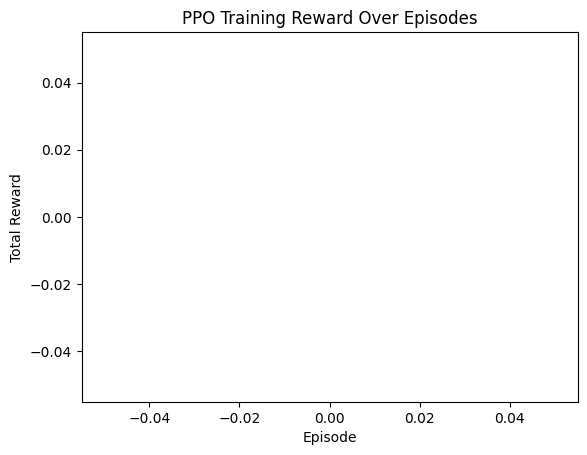

In [15]:
from stable_baselines3 import PPO, DQN, A2C, DDPG, TD3
from gym import Env


env = SupplyChainEnv()
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)
obs = env.reset()
total_reward = 0


for _ in range(100):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    total_reward += reward
    env.render()
    if done:
        break

print(f"Total Reward: {total_reward}")


episode_rewards = []
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('PPO Training Reward Over Episodes')
plt.show()


This second part, compares the performance of other algorithm and plots a graph to see their differences in performance:

PPO, A2C, DDPG, TD3

Training PPO...
PPO training complete.
Training A2C...
A2C training complete.
Training DDPG...
DDPG training complete.
Training TD3...
TD3 training complete.
Evaluating PPO...
PPO evaluation complete.
Evaluating A2C...
A2C evaluation complete.
Evaluating DDPG...
DDPG evaluation complete.
Evaluating TD3...
TD3 evaluation complete.


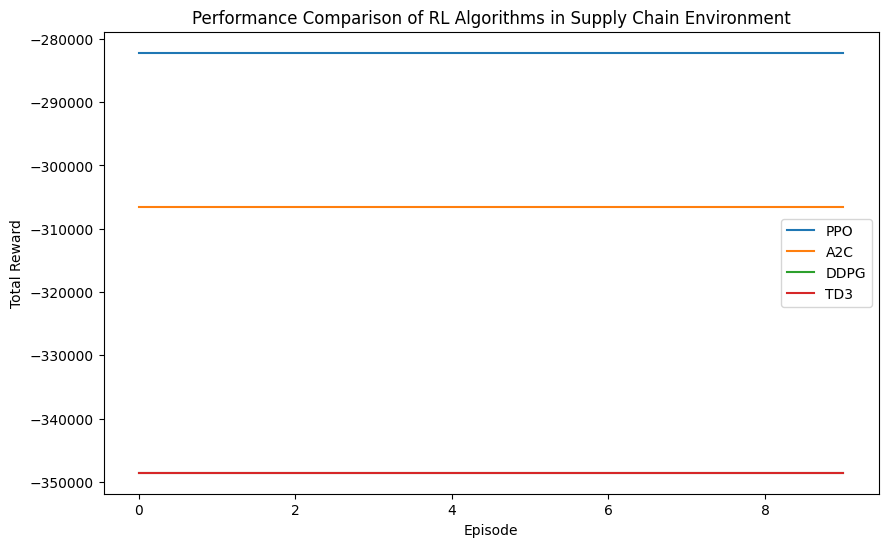

In [18]:
import gym
from gym import spaces
import numpy as np

class SupplyChainEnv(gym.Env):
    def __init__(self):
        super(SupplyChainEnv, self).__init__()
        # Define state and action space (adjust based on your specific needs)
        self.observation_space = spaces.Box(low=0, high=100, shape=(4,), dtype=np.float32)  # Assuming state space
        self.action_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)  # Match action space shape with state

    def reset(self):
        # Reset the environment and return initial state
        self.state = np.array([50, 50, 50, 50])  # Assuming initial state
        return self.state

    def step(self, action):

        self.state = self.state + (action - 0.5)  # Adjusted to match state shape
        reward = -np.sum((self.state - 50) ** 2)  #  Reward calculation
        done = bool(np.any(self.state < 0) or np.any(self.state > 100))
        return self.state, reward, done, {}



from stable_baselines3 import PPO, DQN, A2C, DDPG, TD3
import matplotlib.pyplot as plt


# Instantiate the environment
env = SupplyChainEnv()

# Defining the RL algorithms to compare
algorithms = {
    "PPO": PPO("MlpPolicy", env, verbose=0),
    "A2C": A2C("MlpPolicy", env, verbose=0),
    "DDPG": DDPG("MlpPolicy", env, verbose=0),
    "TD3": TD3("MlpPolicy", env, verbose=0)
}


# Defining total training timesteps
total_timesteps = 20000

# The Dictionary stores trained models
trained_models = {}

# Training each of the model
for algo_name, model in algorithms.items():
    print(f"Training {algo_name}...")
    model.learn(total_timesteps=total_timesteps)
    trained_models[algo_name] = model  # Store trained model
    print(f"{algo_name} training complete.")




def evaluate_model(model, env, n_episodes=10):
    episode_rewards = []
    for _ in range(n_episodes):
        obs = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _ = env.step(action)
            total_reward += reward
        episode_rewards.append(total_reward)
    return episode_rewards



# Dictionary to store evaluation results
results = {}

# Evaluate each trained model
for algo_name, model in trained_models.items():
    print(f"Evaluating {algo_name}...")
    rewards = evaluate_model(model, env)
    results[algo_name] = rewards  # Store rewards for each algorithm
    print(f"{algo_name} evaluation complete.")



plt.figure(figsize=(10, 6))

# Plot total rewards per episode for each algorithm
for algo_name, rewards in results.items():
    plt.plot(rewards, label=algo_name)

plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Performance Comparison of RL Algorithms in Supply Chain Environment")
plt.legend()
plt.show()
